Carlos Garcia - 21000475

In [59]:
from tensorflow import keras

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

### Datos

In [4]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

data = np.concatenate((x_train, x_test), axis = 0)
labels = np.concatenate((y_train, y_test), axis = 0)

In [5]:
print(data.shape)
print(labels.shape)

(70000, 28, 28)
(70000,)


In [58]:
labels_dictionary = dict()
labels_dictionary[0] = 'T-shirt/top'
labels_dictionary[1] = 'Trouser'
labels_dictionary[2] = 'Pullover'
labels_dictionary[3] = 'Dress'
labels_dictionary[4] = 'Coat'
labels_dictionary[5] = 'Sandal'
labels_dictionary[6] = 'Shirt'
labels_dictionary[7] = 'Sneaker'
labels_dictionary[8] = 'Bag'
labels_dictionary[9] = 'Ankle boot'

print(labels_dictionary)

{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


In [6]:
scaler = StandardScaler()
datanorm = np.array([scaler.fit_transform(img) for img in data])

### Reducir dimensionalidad

In [15]:
def getPCA(data, selection = 'pve', k = 0.8):
    #Calculate eigenvalues and eigenvectors
    x = data.reshape(data.shape[0], -1)
    sigma = np.cov(x.T)
    eigen_values, U = np.linalg.eig(sigma) #values, vectors
    
    #Sort matrix
    ranked_idx = np.argsort(eigen_values)[::-1]
    eigen_values[::-1].sort()
    U = U[ranked_idx]
    
    #Get Proportion of variance explained (PVE)
    pve = eigen_values / sum(eigen_values)
    cumPVE = np.cumsum(pve)

    #Select number of components to use
    if selection == 'pve':
        reduce_idx = np.where(cumPVE >= k)[0][0]
        U_reducida = (U.T[:, :reduce_idx])
    else:
        U_reducida = (U.T[:, :k])
    
    #Get Projected data
    Z = np.matmul(U_reducida.T, x.T).T
    
    #plt.plot(np.cumsum(PVE))
    #plt.plot(PVE)
    
    return Z, pve[0:k]

In [11]:
def getTSNE(data, k):
    x = data.reshape(data.shape[0], -1)
    tsne = TSNE(n_components = k)
    x_embedded = tsne.fit_transform(x)
    return x_embedded

In [16]:
pca_matrix, pve = getPCA(datanorm, 'k', 2)

In [27]:
print("Cantidad de varianza preservada con PCA={}".format(np.abs(pve.cumsum())[-1]))

Cantidad de varianza preservada con PCA=0.22747299171018584


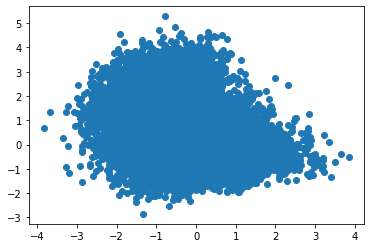

In [42]:
plt.scatter(x = pca_matrix[:, 0].real, y = pca_matrix[:, 1].real)

In [17]:
tsne_matrix = getTSNE(datanorm, 2)

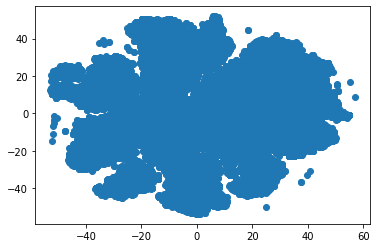

In [43]:
plt.scatter(x = tsne_matrix[:, 0], y = tsne_matrix[:, 1])

#### Conclusiones
- El modelo PCA es computacionalmente más veloz, mientras el modelo TSNE ocupa más recursos y tiempo
- El modelo TSNE muestra una escala mayor, por lo cual podemos ver una mayor dispersión entre los datos, en contraste con el modelo PCA
- Adicionalmente resaltar que el método de PCA permite generar data con muchas más dimensionalidades mientras TSNE se limita a un máximo de 4 dimensiones.

### Clustering

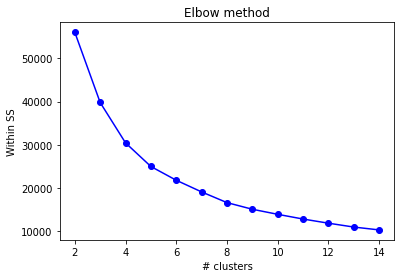

In [46]:
#Elbow method
withinss = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters = k, random_state = 0)
    kmeans.fit(pca_matrix.real)
    withinss.append(kmeans.inertia_)
    
plt.plot(np.arange(2, 15), withinss, 'o-', color = 'blue')
plt.title('Elbow method')
plt.xlabel('# clusters')
plt.ylabel('Within SS')
plt.show()

Según los resultados obtenidos por el método del codo, se selecciona un k = 5

In [57]:
kmeans_pca = KMeans(n_clusters=5, random_state=0).fit(pca_matrix.real)

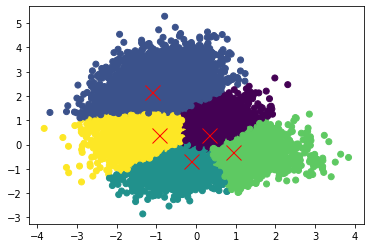

In [48]:
plt.scatter(x = pca_matrix[:, 0].real, y = pca_matrix[:, 1].real, c = kmeans_pca.labels_)
plt.plot(kmeans_pca.cluster_centers_[:, 0], kmeans_pca.cluster_centers_[:, 1], 'rx', markersize = 15)
plt.show()

In [84]:
results = pd.DataFrame({'cluster': kmeans_pca.labels_, 'labels': list(map(labels_dictionary.get, labels)), 'count': np.ones_like(labels)})
results.head()

,cluster,labels,count
0,4,Ankle boot,1
1,2,T-shirt/top,1
2,0,T-shirt/top,1
3,0,Dress,1
4,3,T-shirt/top,1


In [85]:
results.pivot_table(values = 'count', index = 'cluster', columns = 'labels', aggfunc = np.sum)

labels,Ankle boot,Bag,Coat,Dress,Pullover,Sandal,Shirt,Sneaker,T-shirt/top,Trouser
cluster,,,,,,,,,,
0,264.0,1603.0,2801.0,1992.0,2172.0,713.0,2817.0,173.0,3570.0,2162.0
1,323.0,718.0,22.0,43.0,87.0,2244.0,129.0,4939.0,104.0,38.0
2,4875.0,851.0,1545.0,1614.0,2935.0,2466.0,1902.0,370.0,542.0,438.0
3,55.0,579.0,2310.0,2244.0,1174.0,197.0,1443.0,3.0,1960.0,4162.0
4,1483.0,3249.0,322.0,1107.0,632.0,1380.0,709.0,1515.0,824.0,200.0


#### Conclusiones
- No en todos los clusters se realizaron agrupaciones de prendas similares. Sin embargo, en algunos clusters como el cluster 0, es posible ver una clara agrupación pues contiene principalmente las etiquetas (coat, pullover, t-shirt, shirt) siendo todas estas para la parte superior del cuerpo. 

### Conclusiones Generales
- En general trabajar con un mayor número de dimensiones mejoraría la cantidad de varianza explicada y lo resultados obtenidos en el modelo de clustering. 
- La reducción de dimensionalidades es una técnica de gran utilidad para mejorar el funcionamiento de otros algoritmos, como en este caso pasar de 784 a 2 dimensiones.